In [2]:
import numpy as np
import pandas as pd


#Defining the warehouse environment as a class with state transition and reward function


In [3]:
class WarehouseEnvironment:
    def __init__(self, grid, start, target):
        self.grid = grid
        self.start = start
        self.target = target
        self.state = start
        self.actions = ['up', 'down', 'left', 'right']

    def step(self, action):
        next_state = self._get_next_state(action)
        reward = self._get_reward(next_state)
        self.state = next_state
        done = (next_state == self.target)
        return next_state, reward, done

    def reset(self):
        self.state = self.start
        return self.state
  

    def _get_next_state(self, action):
        row, col = self.state
        if action == 'up':
            row = max(row - 1, 0)
        elif action == 'down':
            row = min(row + 1, len(self.grid) - 1)
        elif action == 'left':
            col = max(col - 1, 0)
        elif action == 'right':
            col = min(col + 1, len(self.grid[0]) - 1)
        next_state = (row, col)
        return next_state if self.grid[row][col] != 'obstacle' else self.state

    def _get_reward(self, next_state):
        row, col = next_state
        if next_state == self.target:
            return 100
        elif self.grid[row][col] == 'obstacle':
            return -100
        else:
            return -1


We create an instance of the WarehouseEnvironment class by providing a grid, start position, and target position. The grid is a  2D list containing 'empty', 'obstacle', 'start', or 'target' values

In [4]:
grid = [
    ['start', 'empty', 'empty', 'empty'],
    ['empty', 'obstacle', 'empty', 'empty'],
    ['empty', 'obstacle', 'empty', 'obstacle'],
    ['empty', 'empty', 'empty', 'target']
]

start = (0, 0)
target = (3, 3)

env = WarehouseEnvironment(grid, start, target)


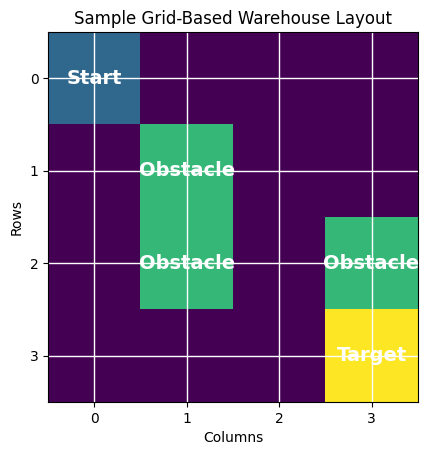

In [5]:
import matplotlib.pyplot as plt

def draw_warehouse(grid):
    warehouse = []
    for row in grid:
        warehouse_row = []
        for cell in row:
            if cell == 'start':
                warehouse_row.append(1)
            elif cell == 'empty':
                warehouse_row.append(0)
            elif cell == 'obstacle':
                warehouse_row.append(2)
            elif cell == 'target':
                warehouse_row.append(3)
        warehouse.append(warehouse_row)

    plt.imshow(warehouse, cmap='viridis', origin='upper')
    plt.xticks(range(len(grid[0])), range(len(grid[0])))
    plt.yticks(range(len(grid)), range(len(grid)))
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.title('Sample Grid-Based Warehouse Layout')

    # Add text labels for start, target, and obstacle cells
    for row in range(len(grid)):
        for col in range(len(grid[0])):
            if grid[row][col] == 'start':
                plt.text(col, row, 'Start', ha='center', va='center', color='white', fontsize=14, fontweight='bold')
            elif grid[row][col] == 'target':
                plt.text(col, row, 'Target', ha='center', va='center', color='white', fontsize=14, fontweight='bold')
            elif grid[row][col] == 'obstacle':
                plt.text(col, row, 'Obstacle', ha='center', va='center', color='white', fontsize=14, fontweight='bold')

    plt.grid(color='white', linewidth=1)
    plt.show()

grid = [
    ['start', 'empty', 'empty', 'empty'],
    ['empty', 'obstacle', 'empty', 'empty'],
    ['empty', 'obstacle', 'empty', 'obstacle'],
    ['empty', 'empty', 'empty', 'target']
]

draw_warehouse(grid)


#We implement the Q-learning algorithm

In [6]:
import numpy as np
import random

# Q-learning parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1
num_episodes = 500

# Initialize the Q-table
num_rows, num_cols = len(grid), len(grid[0])
q_table = np.zeros((num_rows, num_cols, len(env.actions)))

def choose_action(state):
    if random.uniform(0, 1) < epsilon:
        return random.choice(env.actions)
    else:
        row, col = state
        return env.actions[np.argmax(q_table[row, col])]

def update_q_table(state, action, next_state, reward):
    row, col = state
    action_idx = env.actions.index(action)
    next_row, next_col = next_state
    q_table[row, col, action_idx] += alpha * (reward + gamma * np.max(q_table[next_row, next_col]) - q_table[row, col, action_idx])


In [7]:
cumulative_rewards = []
steps_per_episode = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    steps = 0
    
    while True:
        action = choose_action(state)
        next_state, reward, done = env.step(action)
        update_q_table(state, action, next_state, reward)
        
        state = next_state
        total_reward += reward
        steps += 1

        if done:
            break
    
    cumulative_rewards.append(total_reward)
    steps_per_episode.append(steps)
    epsilon *= 0.99  # Decay epsilon


#We represent the performance by plotting the cumulative rewards and steps taken per episode.

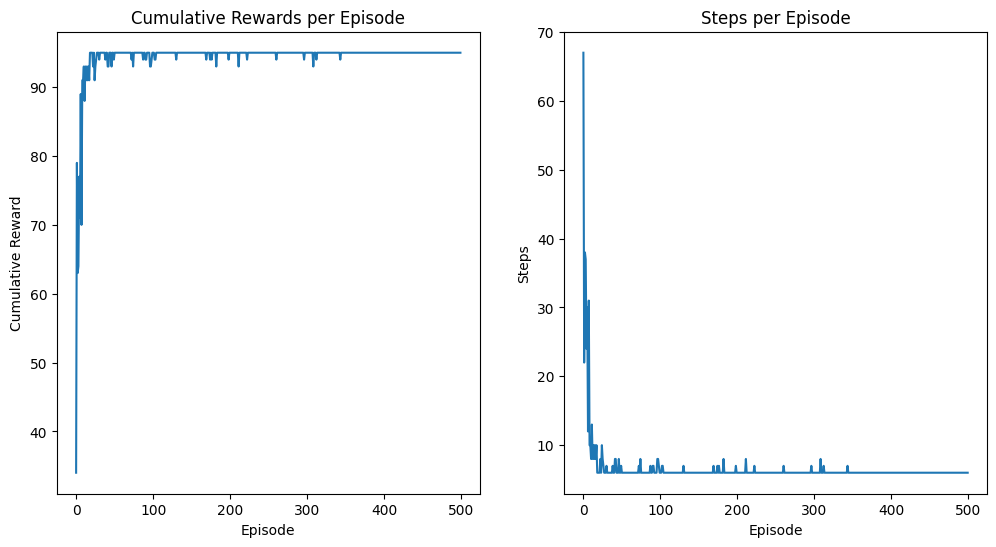

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards per Episode')

plt.subplot(1, 2, 2)
plt.plot(steps_per_episode)
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps per Episode')

plt.show()


## First, we experiment with varying epsilon value and implement the SARSA algorithm.

In [10]:
def train_rl_algorithm(env, algorithm, alpha, gamma, epsilon, num_episodes):
    q_table = np.zeros((num_rows, num_cols, len(env.actions)))
    action_indices = {action: i for i, action in enumerate(env.actions)}

    def choose_action(state, epsilon):
        row, col = state
        if random.uniform(0, 1) < epsilon:
            chosen_action = random.choice(env.actions)
        else:
            chosen_action = env.actions[np.argmax(q_table[row, col])]
        return chosen_action

    cumulative_rewards = []
    steps_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        steps = 0

        while True:
            action = choose_action(state, epsilon)
            next_state, reward, done = env.step(action)
            next_action = choose_action(next_state, epsilon)

            row, col = state
            action_idx = action_indices[action]
            next_row, next_col = next_state
            next_action_idx = action_indices[next_action]

            if algorithm == 'q_learning':
                target = reward + gamma * np.max(q_table[next_row, next_col])
            elif algorithm == 'sarsa':
                target = reward + gamma * q_table[next_row, next_col, next_action_idx]

            q_table[row, col, action_idx] += alpha * (target - q_table[row, col, action_idx])

            state = next_state
            total_reward += reward
            steps += 1

            if done:
                break

        cumulative_rewards.append(total_reward)
        steps_per_episode.append(steps)
        epsilon *= 0.99

    return cumulative_rewards, steps_per_episode


In [11]:
epsilon_values = [0.1, 0.3, 0.5]
algorithms = ['q_learning', 'sarsa']

results = {}

for algorithm in algorithms:
    for epsilon in epsilon_values:
        print(f"Running {algorithm} with epsilon={epsilon}")
        key = f"{algorithm}_epsilon_{epsilon}"
        cumulative_rewards, steps_per_episode = train_rl_algorithm(env, algorithm, alpha, gamma, epsilon, num_episodes)
        results[key] = {'cumulative_rewards': cumulative_rewards, 'steps_per_episode': steps_per_episode}


Running q_learning with epsilon=0.1
Running q_learning with epsilon=0.3
Running q_learning with epsilon=0.5
Running sarsa with epsilon=0.1
Running sarsa with epsilon=0.3
Running sarsa with epsilon=0.5


##Plotes for Epsilon

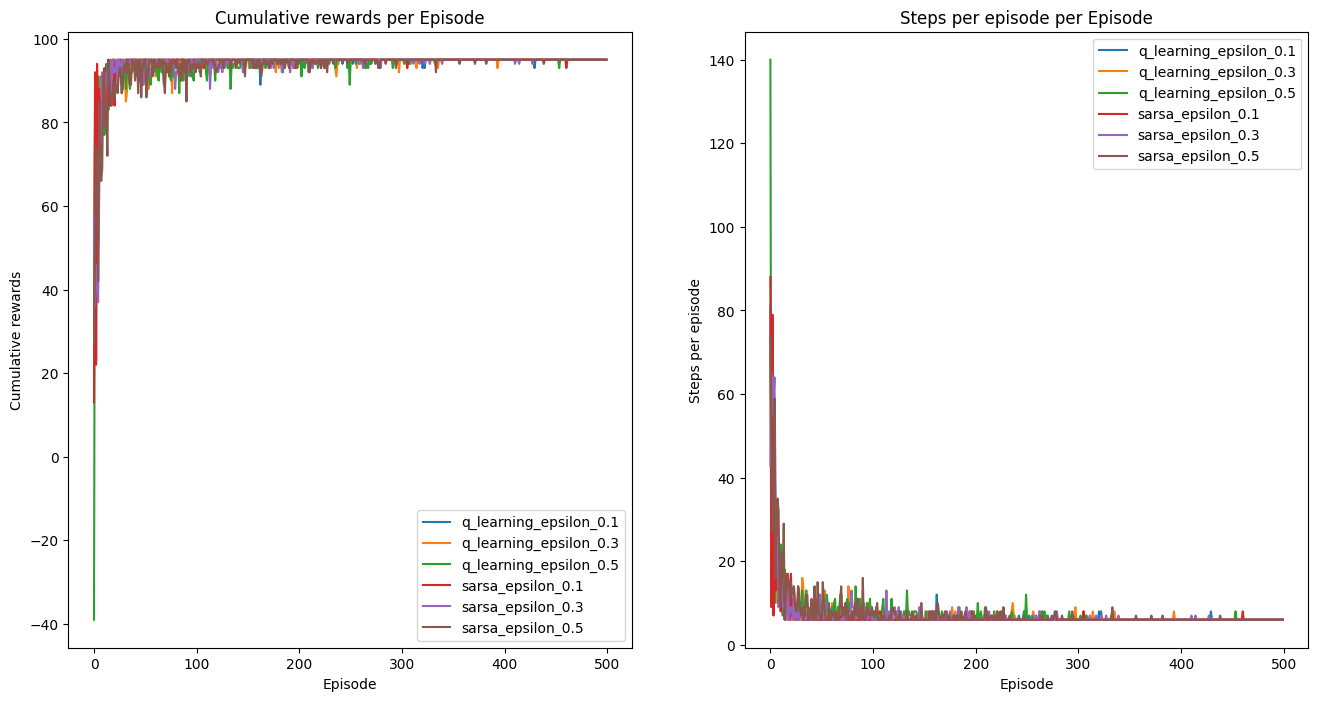

In [12]:
plt.figure(figsize=(16, 8))

for idx, metric in enumerate(['cumulative_rewards', 'steps_per_episode']):
    plt.subplot(1, 2, idx + 1)
    for key, data in results.items():
        plt.plot(data[metric], label=key)
    plt.xlabel('Episode')
    plt.ylabel(metric.capitalize().replace('_', ' '))
    plt.title(f"{metric.capitalize().replace('_', ' ')} per Episode")
    plt.legend()

plt.show()


#Now we experiment with Alpha and Gamma

In [13]:
alphas = [0.1, 0.5, 0.9]
gammas = [0.8, 0.95]
epsilon = 0.1
num_episodes = 500
algorithms = ['q_learning', 'sarsa']

results = {}

for algorithm in algorithms:
    for alpha in alphas:
        for gamma in gammas:
            key = f"{algorithm} - alpha={alpha}, gamma={gamma}"
            print(f"Running {key}")
            cumulative_rewards, steps_per_episode = train_rl_algorithm(env, algorithm, alpha, gamma, epsilon, num_episodes)
            results[key] = {'cumulative_rewards': cumulative_rewards, 'steps_per_episode': steps_per_episode}


Running q_learning - alpha=0.1, gamma=0.8
Running q_learning - alpha=0.1, gamma=0.95
Running q_learning - alpha=0.5, gamma=0.8
Running q_learning - alpha=0.5, gamma=0.95
Running q_learning - alpha=0.9, gamma=0.8
Running q_learning - alpha=0.9, gamma=0.95
Running sarsa - alpha=0.1, gamma=0.8
Running sarsa - alpha=0.1, gamma=0.95
Running sarsa - alpha=0.5, gamma=0.8
Running sarsa - alpha=0.5, gamma=0.95
Running sarsa - alpha=0.9, gamma=0.8
Running sarsa - alpha=0.9, gamma=0.95


In [ ]:
window_size = 10

for key, data in results.items():
    cumulative_rewards = data['cumulative_rewards']
    steps_per_episode = data['steps_per_episode']
    
    avg_cumulative_rewards = [np.mean(cumulative_rewards[i:i+window_size]) for i in range(0, len(cumulative_rewards), window_size)]
    avg_steps_per_episode = [np.mean(steps_per_episode[i:i+window_size]) for i in range(0, len(steps_per_episode), window_size)]
    
    print(f"{key}:")
    print(f"  Average Cumulative Rewards (window size={window_size}): {avg_cumulative_rewards}")
    print(f"  Average Steps per Episode (window size={window_size}): {avg_steps_per_episode}")
    print()


##Plots for Alpha

##Different alpha values for Q-learning and SARSA, while keeping gamma constant ( gamma = 0.95):

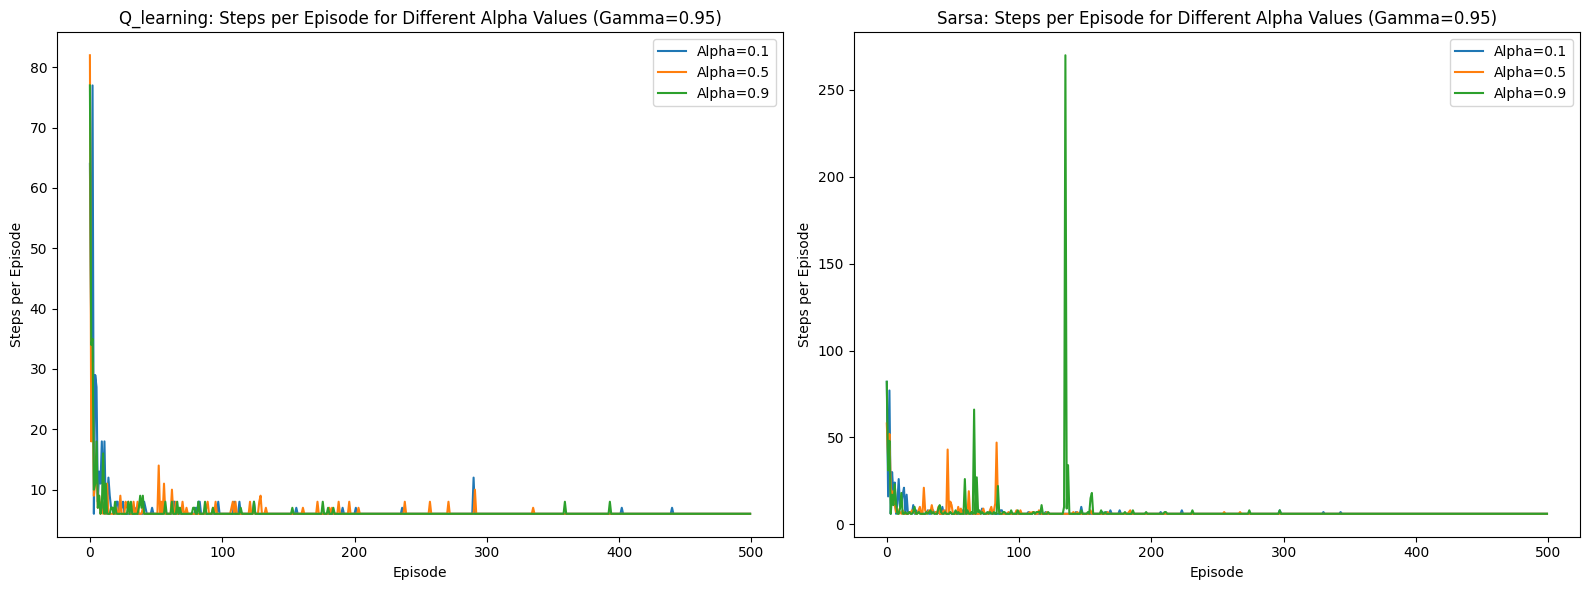

In [14]:
plt.figure(figsize=(16, 6))

constant_gamma = 0.95

for idx, algorithm in enumerate(algorithms):
    plt.subplot(1, 2, idx + 1)

    for key, data in results.items():
        algorithm_from_key, alpha_gamma = key.split(' - ')
        if algorithm_from_key == algorithm:
            alpha_str, gamma_str = alpha_gamma.split(', ')
            _, alpha_val = alpha_str.split('=')
            _, gamma_val = gamma_str.split('=')
            alpha = float(alpha_val)
            gamma = float(gamma_val)
            
            if gamma == constant_gamma:
                plt.plot(data['steps_per_episode'], label=f'Alpha={alpha}')

    plt.xlabel('Episode')
    plt.ylabel('Steps per Episode')
    plt.title(f"{algorithm.capitalize()}: Steps per Episode for Different Alpha Values (Gamma={constant_gamma})")
    plt.legend()

plt.tight_layout()
plt.show()


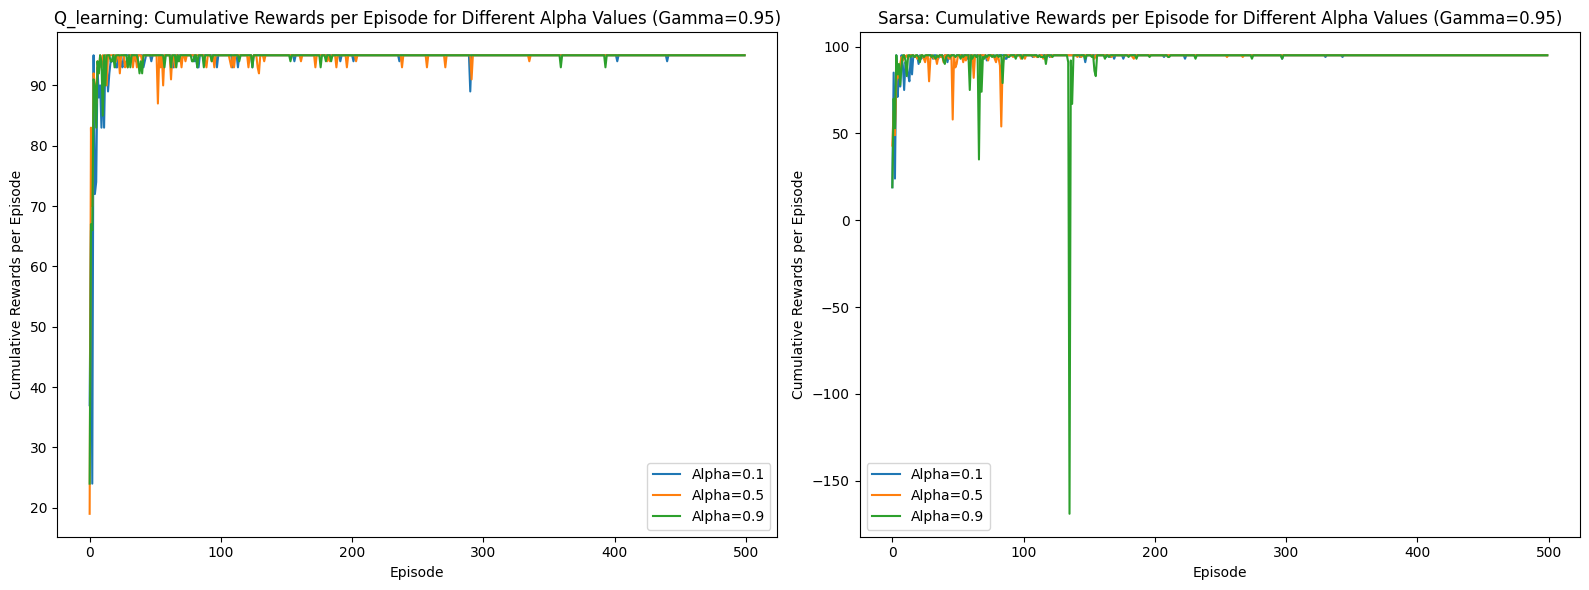

In [15]:
plt.figure(figsize=(16, 6))

constant_gamma = 0.95

for idx, algorithm in enumerate(algorithms):
    plt.subplot(1, 2, idx + 1)

    for key, data in results.items():
        algorithm_from_key, alpha_gamma = key.split(' - ')
        if algorithm_from_key == algorithm:
            alpha_str, gamma_str = alpha_gamma.split(', ')
            _, alpha_val = alpha_str.split('=')
            _, gamma_val = gamma_str.split('=')
            alpha = float(alpha_val)
            gamma = float(gamma_val)
            
            if gamma == constant_gamma:
                plt.plot(data['cumulative_rewards'], label=f'Alpha={alpha}')

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Rewards per Episode')
    plt.title(f"{algorithm.capitalize()}: Cumulative Rewards per Episode for Different Alpha Values (Gamma={constant_gamma})")
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
key

'sarsa - alpha=0.9, gamma=0.95'

##Plots for gamma

##Gamma values for Q-learning and SARSA, while keeping alpha constant (alpha = 0.5):

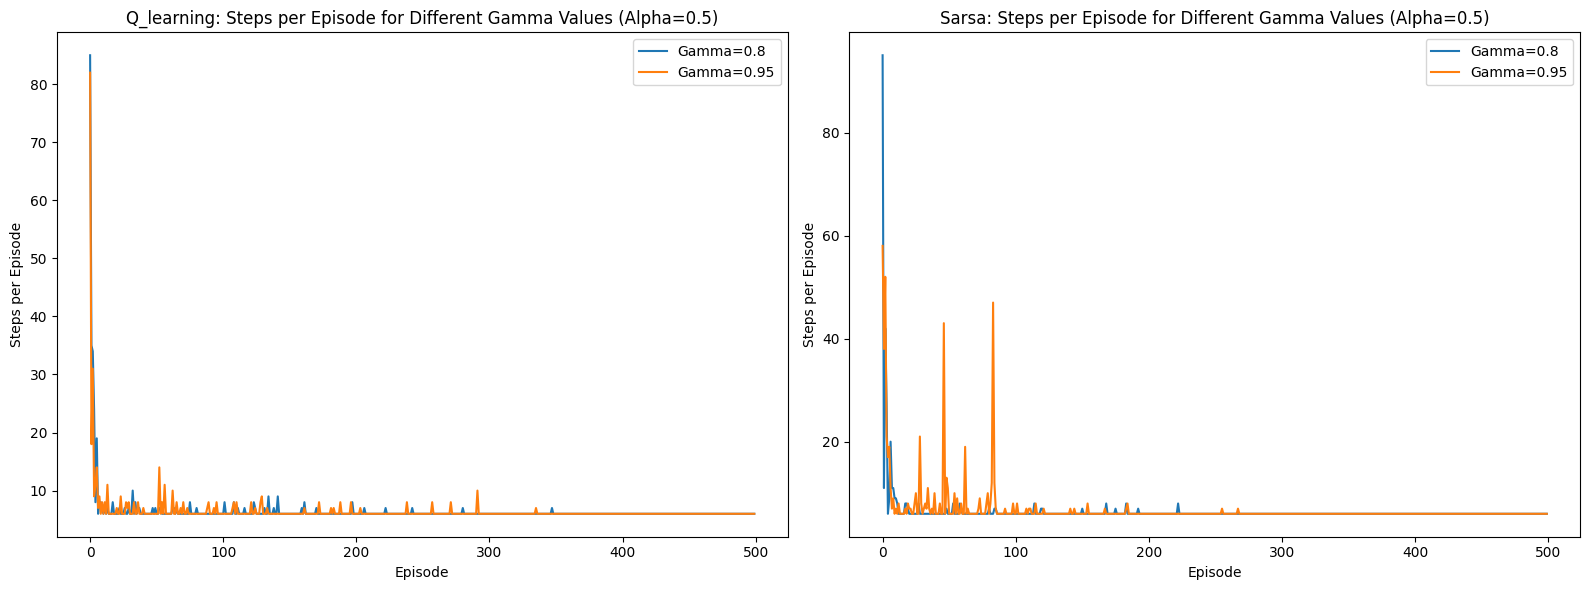

In [16]:
plt.figure(figsize=(16, 6))

constant_alpha = 0.5

for idx, algorithm in enumerate(algorithms):
    plt.subplot(1, 2, idx + 1)

    for key, data in results.items():
        algorithm_from_key, alpha_gamma = key.split(' - ')
        if algorithm_from_key == algorithm:
            alpha_str, gamma_str = alpha_gamma.split(', ')
            _, alpha_val = alpha_str.split('=')
            _, gamma_val = gamma_str.split('=')
            alpha = float(alpha_val)
            gamma = float(gamma_val)
            
            if alpha == constant_alpha:
                plt.plot(data['steps_per_episode'], label=f'Gamma={gamma}')

    plt.xlabel('Episode')
    plt.ylabel('Steps per Episode')
    plt.title(f"{algorithm.capitalize()}: Steps per Episode for Different Gamma Values (Alpha={constant_alpha})")
    plt.legend()

plt.tight_layout()
plt.show()


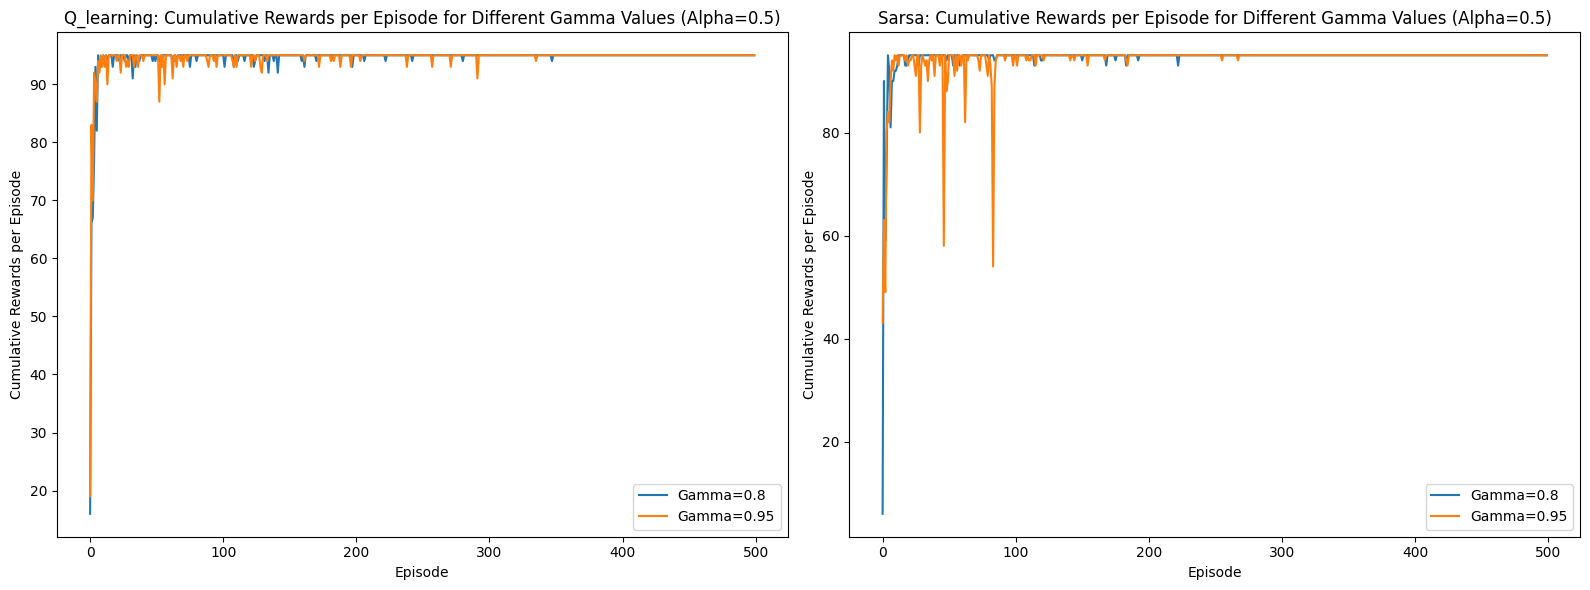

In [17]:
plt.figure(figsize=(16, 6))

constant_alpha = 0.5

for idx, algorithm in enumerate(algorithms):
    plt.subplot(1, 2, idx + 1)

    for key, data in results.items():
        algorithm_from_key, alpha_gamma = key.split(' - ')
        if algorithm_from_key == algorithm:
            alpha_str, gamma_str = alpha_gamma.split(', ')
            _, alpha_val = alpha_str.split('=')
            _, gamma_val = gamma_str.split('=')
            alpha = float(alpha_val)
            gamma = float(gamma_val)
            
            if alpha == constant_alpha:
                plt.plot(data['cumulative_rewards'], label=f'Gamma={gamma}')

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Rewards per Episode')
    plt.title(f"{algorithm.capitalize()}: Cumulative Rewards per Episode for Different Gamma Values (Alpha={constant_alpha})")
    plt.legend()

plt.tight_layout()
plt.show()


#Compare the performance of 2 policy

In [19]:
from math import exp
def train_rl_algorithm_with_policy(env, algorithm, alpha, gamma, epsilon, num_episodes, exploration_strategy):
    q_table = np.zeros((num_rows, num_cols, len(env.actions)))
    action_indices = {action: i for i, action in enumerate(env.actions)}

    def choose_action(state, epsilon, exploration_strategy):
        row, col = state
        if exploration_strategy == 'epsilon_greedy':
            if random.uniform(0, 1) < epsilon:
                chosen_action = random.choice(env.actions)
            else:
                chosen_action = env.actions[np.argmax(q_table[row, col])]
        elif exploration_strategy == 'softmax':
            q_values = q_table[row, col]
            action_probabilities = softmax(q_values)
            chosen_action = env.actions[np.random.choice(len(env.actions), p=action_probabilities)]
        return chosen_action

    def softmax(q_values, tau=1.0):
        q_values_exp = np.exp(np.array(q_values) / tau)
        return q_values_exp / np.sum(q_values_exp)

    cumulative_rewards = []
    steps_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        steps = 0

        while True:
            action = choose_action(state, epsilon, exploration_strategy)
            next_state, reward, done = env.step(action)
            next_action = choose_action(next_state, epsilon, exploration_strategy)

            row, col = state
            action_idx = action_indices[action]
            next_row, next_col = next_state
            next_action_idx = action_indices[next_action]

            if algorithm == 'q_learning':
                target = reward + gamma * np.max(q_table[next_row, next_col])
            elif algorithm == 'sarsa':
                target = reward + gamma * q_table[next_row, next_col, next_action_idx]

            q_table[row, col, action_idx] += alpha * (target - q_table[row, col, action_idx])

            state = next_state
            total_reward += reward
            steps += 1

            if done:
                break

        cumulative_rewards.append(total_reward)
        steps_per_episode.append(steps)
        epsilon *= 0.99

    return cumulative_rewards, steps_per_episode

results = {}
exploration_strategies = ['epsilon_greedy', 'softmax']
algorithms = ['q_learning', 'sarsa']

for algorithm in algorithms:
    for exploration_strategy in exploration_strategies:
        key = f"{algorithm}_{exploration_strategy}"
        print(f"Running {algorithm} with {exploration_strategy}")
        cumulative_rewards, steps_per_episode = train_rl_algorithm_with_policy(env, algorithm, alpha, gamma, epsilon, num_episodes, exploration_strategy)
        results[key] = {'cumulative_rewards': cumulative_rewards, 'steps_per_episode': steps_per_episode}



Running q_learning with epsilon_greedy
Running q_learning with softmax
Running sarsa with epsilon_greedy
Running sarsa with softmax


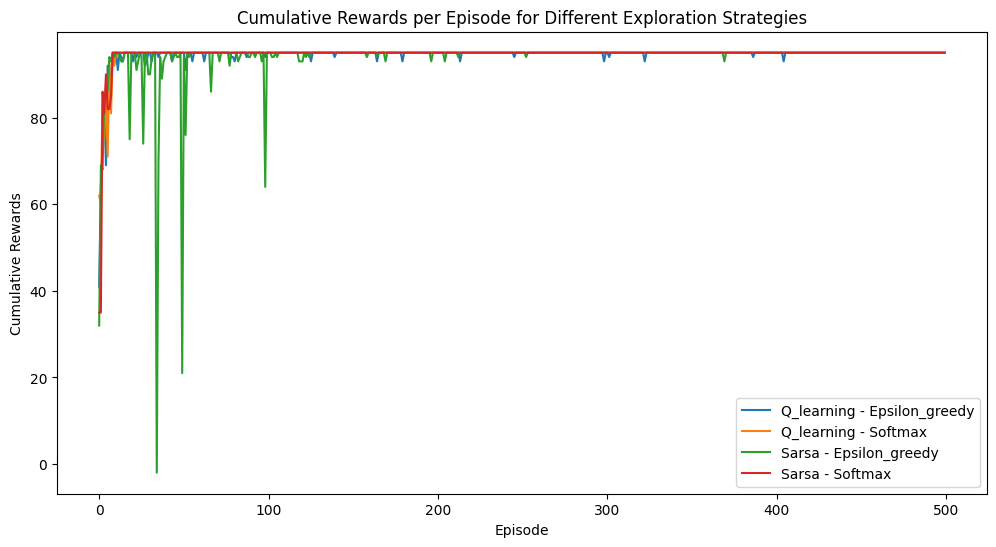

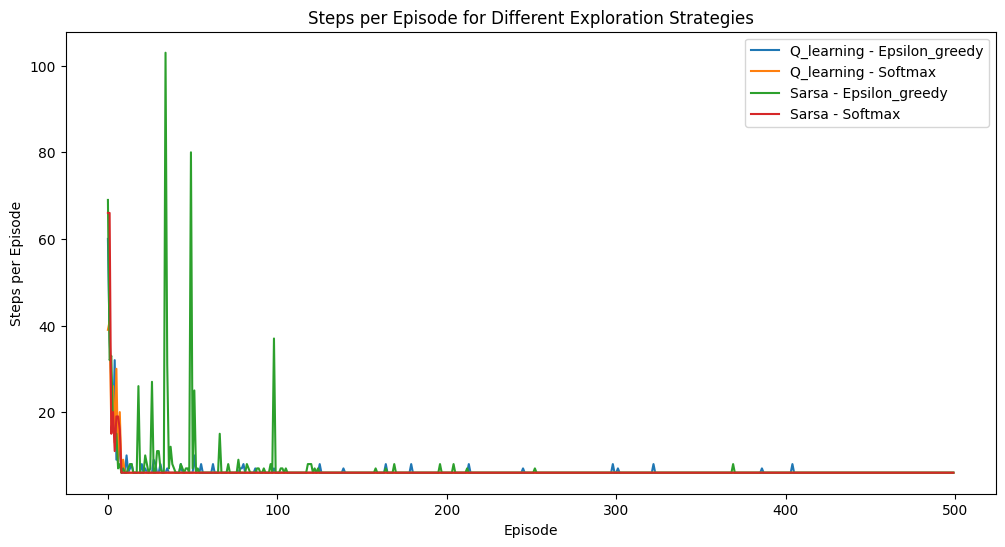

In [20]:
import matplotlib.pyplot as plt

# Plotting the Cumulative Rewards per Episode
plt.figure(figsize=(12, 6))

for idx, algorithm in enumerate(algorithms):
    for exploration_strategy in exploration_strategies:
        key = f"{algorithm}_{exploration_strategy}"
        data = results[key]
        label = f"{algorithm.capitalize()} - {exploration_strategy.capitalize()}"
        plt.plot(data['cumulative_rewards'], label=label)

plt.xlabel('Episode')
plt.ylabel('Cumulative Rewards')
plt.title('Cumulative Rewards per Episode for Different Exploration Strategies')
plt.legend()
plt.show()

# Plotting the Steps per Episode
plt.figure(figsize=(12, 6))

for idx, algorithm in enumerate(algorithms):
    for exploration_strategy in exploration_strategies:
        key = f"{algorithm}_{exploration_strategy}"
        data = results[key]
        label = f"{algorithm.capitalize()} - {exploration_strategy.capitalize()}"
        plt.plot(data['steps_per_episode'], label=label)

plt.xlabel('Episode')
plt.ylabel('Steps per Episode')
plt.title('Steps per Episode for Different Exploration Strategies')
plt.legend()
plt.show()


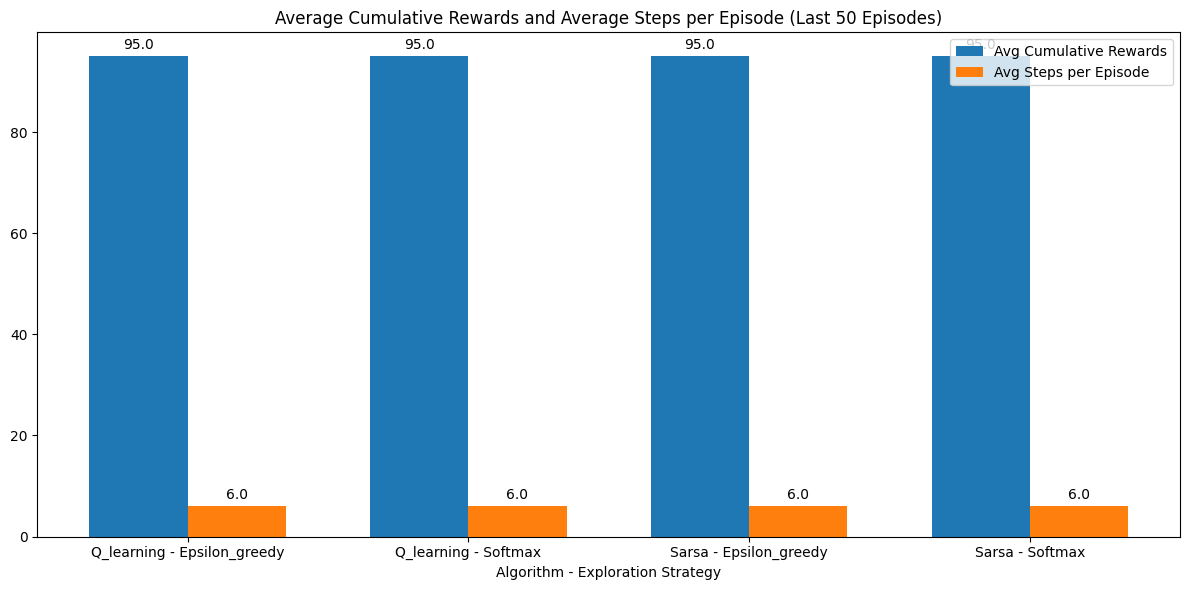

In [21]:
avg_cumulative_rewards = {}
avg_steps_per_episode = {}

for idx, algorithm in enumerate(algorithms):
    for exploration_strategy in exploration_strategies:
        key = f"{algorithm}_{exploration_strategy}"
        data = results[key]
        avg_cumulative_rewards[key] = np.mean(data['cumulative_rewards'][-50:])
        avg_steps_per_episode[key] = np.mean(data['steps_per_episode'][-50:])

# Creating a bar chart for the average cumulative rewards and average steps per episode
x_labels = [f"{algorithm.capitalize()} - {exploration_strategy.capitalize()}" for algorithm in algorithms for exploration_strategy in exploration_strategies]
x = np.arange(len(x_labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))
rects1 = ax1.bar(x - width / 2, [avg_cumulative_rewards[f"{algorithm}_{exploration_strategy}"] for algorithm in algorithms for exploration_strategy in exploration_strategies], width, label='Avg Cumulative Rewards')
rects2 = ax1.bar(x + width / 2, [avg_steps_per_episode[f"{algorithm}_{exploration_strategy}"] for algorithm in algorithms for exploration_strategy in exploration_strategies], width, label='Avg Steps per Episode')

ax1.set_xlabel('Algorithm - Exploration Strategy')
ax1.set_title('Average Cumulative Rewards and Average Steps per Episode (Last 50 Episodes)')
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels)
ax1.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax1.annotate(f"{height:.1f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()


#Outcome of various reward structures

Reward Function 1:

+100 for reaching the target

-100 for hitting an obstacle

-2 for any other move

Reward Function 2:

+200 for reaching the target

-50 for hitting an obstacle

-1 for any other move

-5 for moving into a corner cell (except the target cell)

In [22]:
import numpy as np
import random

class WarehouseEnvironmentModified(WarehouseEnvironment):
    def __init__(self, grid, start, target, reward_function):
        super().__init__(grid, start, target)
        self.reward_function = reward_function

    def _get_reward(self, next_state):
        return self.reward_function(next_state, self.grid, self.target)

def reward_function_1(next_state, grid, target):
    row, col = next_state
    if next_state == target:
        return 100
    elif grid[row][col] == 'obstacle':
        return -100
    else:
        return -1

def reward_function_2(next_state, grid, target):
    row, col = next_state
    if next_state == target:
        return 500
    elif grid[row][col] == 'obstacle':
        return -500
    else:
        return -5

def reward_function_3(next_state, grid, target):
    row, col = next_state
    if next_state == target:
        return 100
    elif grid[row][col] == 'obstacle':
        return -100
    else:
        return -1 * (abs(row - target[0]) + abs(col - target[1]))


In [23]:
class WarehouseEnvironmentModified(WarehouseEnvironment):
    def __init__(self, grid, start, target, reward_function):
        super().__init__(grid, start, target)
        self.reward_function = reward_function

    def _get_reward(self, next_state):
        return self.reward_function(next_state, self.grid, self.target)

def reward_function_1(next_state, grid, target):
    row, col = next_state
    if next_state == target:
        return 100
    elif grid[row][col] == 'obstacle':
        return -100
    else:
        return -1

def reward_function_2(next_state, grid, target):
    row, col = next_state
    if next_state == target:
        return 500
    elif grid[row][col] == 'obstacle':
        return -500
    else:
        return -5

def reward_function_3(next_state, grid, target):
    row, col = next_state
    if next_state == target:
        return 100
    elif grid[row][col] == 'obstacle':
        return -100
    else:
        return -1 * (abs(row - target[0]) + abs(col - target[1]))


In [24]:
env1 = WarehouseEnvironmentModified(grid, start, target, reward_function_1)
env2 = WarehouseEnvironmentModified(grid, start, target, reward_function_2)
env3 = WarehouseEnvironmentModified(grid, start, target, reward_function_3)

In [25]:
envs = (env1,env2,env3)

In [26]:
def train_rl_algorithm_with_reward(env, algorithm, alpha, gamma, epsilon, num_episodes, max_steps):
    q_table = np.zeros((num_rows, num_cols, len(env.actions)))
    
    action_indices = {action: i for i, action in enumerate(env.actions)}

    def choose_action(state, epsilon):
        row, col = state
        if random.uniform(0, 1) < epsilon:
            return random.choice(env.actions)
        else:
            return env.actions[np.argmax(q_table[row, col])]

    cumulative_rewards = []
    steps_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        steps = 0

        while True:
            action = choose_action(state, epsilon)
            next_state, reward, done = env.step(action)
            next_action = choose_action(next_state, epsilon)

            row, col = state
            action_idx = action_indices[action]
            next_row, next_col = next_state
            next_action_idx = action_indices[next_action]

            if algorithm == 'q_learning':
                q_table[row, col, action_idx] += alpha * (reward + gamma * np.max(q_table[next_row, next_col]) - q_table[row, col, action_idx])
            elif algorithm == 'sarsa':
                q_table[row, col, action_idx] += alpha * (reward + gamma * q_table[next_row, next_col, next_action_idx] - q_table[row, col, action_idx])

            state = next_state
            total_reward += reward
            steps += 1

            if done or steps >= max_steps:
                break

        cumulative_rewards.append(total_reward)
        steps_per_episode.append(steps)
        epsilon *= 0.99

    return cumulative_rewards, steps_per_episode


results = {}

for algorithm in algorithms:
    for env_idx, env in enumerate(envs):
        key = f"{algorithm} - reward_function{env_idx+1}"
        print(f"Running {key}")
        cumulative_rewards, steps_per_episode = train_rl_algorithm_with_reward(env, algorithm, alpha, gamma, epsilon, num_episodes, max_steps=500)
        results[key] = {'cumulative_rewards': cumulative_rewards, 'steps_per_episode': steps_per_episode}


Running q_learning - reward_function1
Running q_learning - reward_function2
Running q_learning - reward_function3
Running sarsa - reward_function1
Running sarsa - reward_function2
Running sarsa - reward_function3


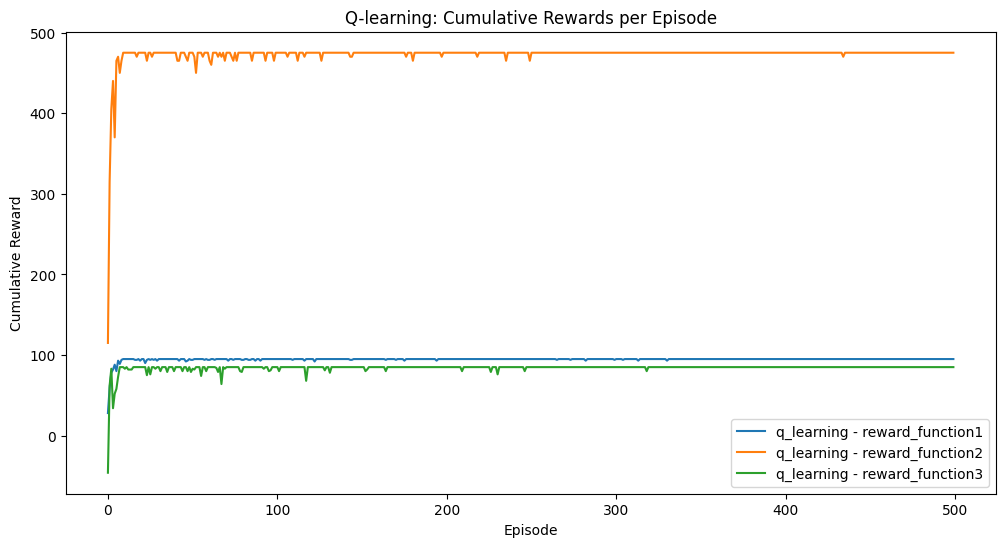

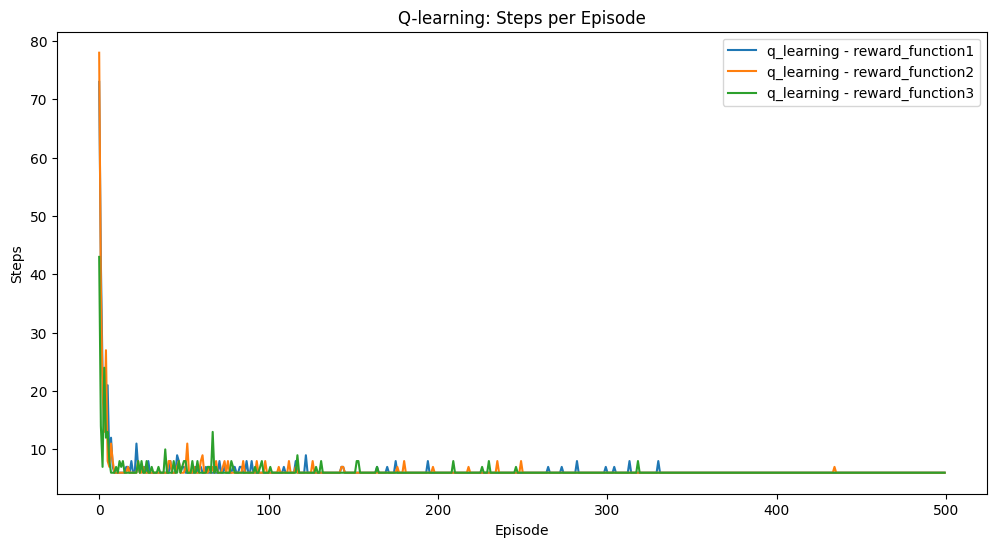

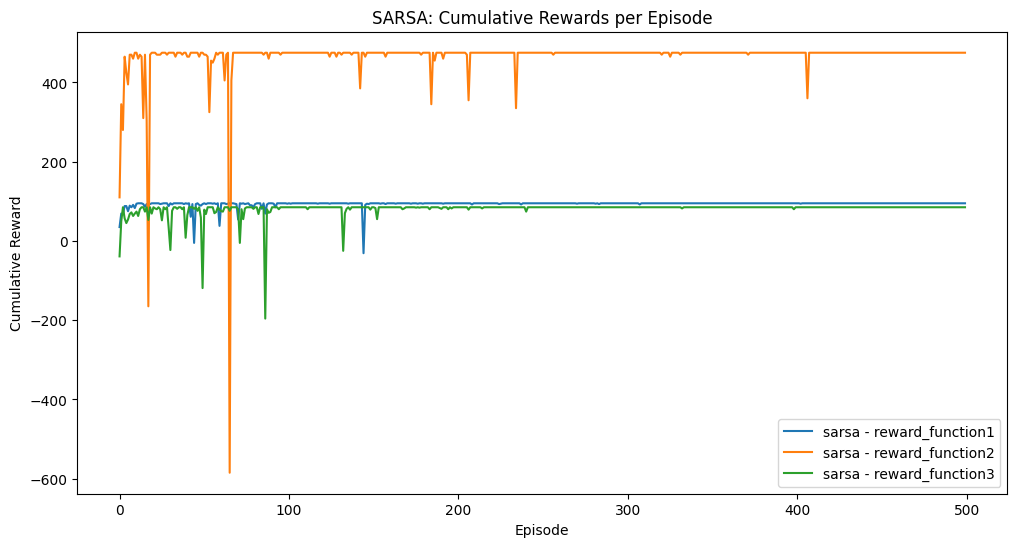

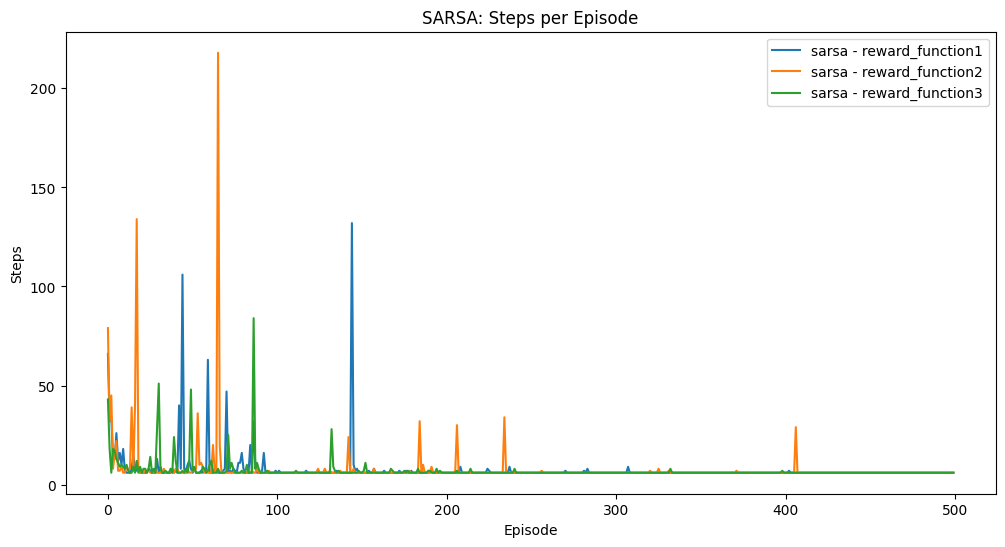

In [27]:
import matplotlib.pyplot as plt

def plot_results(results, metric, ylabel, title):
    plt.figure(figsize=(12, 6))
    
    for key, value in results.items():
        plt.plot(value[metric], label=key)

    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Q-learning
q_learning = {key: value for key, value in results.items() if "q_learning" in key}
plot_results(q_learning, 'cumulative_rewards', 'Cumulative Reward', 'Q-learning: Cumulative Rewards per Episode')
plot_results(q_learning, 'steps_per_episode', 'Steps', 'Q-learning: Steps per Episode')

# SARSA
sarsa = {key: value for key, value in results.items() if "sarsa" in key}
plot_results(sarsa, 'cumulative_rewards', 'Cumulative Reward', 'SARSA: Cumulative Rewards per Episode')
plot_results(sarsa, 'steps_per_episode', 'Steps', 'SARSA: Steps per Episode')


#Analysing the result

In [ ]:
# Compute average cumulative rewards over the last few episodes
num_last_episodes = 50

avg_cumulative_rewards = {}
for key, value in results.items():
    avg_cumulative_rewards[key] = sum(value['cumulative_rewards'][-num_last_episodes:]) / num_last_episodes

# Find the best reward function for each algorithm
best_reward_functions = {}
for algorithm in algorithms:
    best_reward_function = None
    best_reward = float('-inf')
    
    for key, avg_reward in avg_cumulative_rewards.items():
        if algorithm in key and avg_reward > best_reward:
            best_reward = avg_reward
            best_reward_function = key.split('-')[-1].strip()
    
    best_reward_functions[algorithm] = best_reward_function

print("Best performing reward functions:")
print(best_reward_functions)


Best performing reward functions:
{'q_learning': 'reward_function2', 'sarsa': 'reward_function2'}
